# **CAPSTONE PROJECT - Time Series-Based Daily Financial Predictor**

**📌 Project Overview**

This project is part of a capstone project called
**PocketWise**
that aims to build an intelligent system that can provide data-based personal finance recommendations. The main focus of this project is on daily financial prediction using time series modeling, serving as the foundation for building a system that understands and anticipates users' spending behaviors.

Unlike conventional approaches that rely on public datasets, this project utilizes real daily spending data from an individual, which reflects actual, day-to-day financial habits—including categories such as food, transportation, entertainment, bills, and more. By using authentic, behavior-based data, the models developed are expected to provide more personalized and realistic financial insights to assist users in managing their finances better.



# **1. Import Libraries**

In [1]:
# Import libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import libraries for preprocessing and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Import Keras libraries for building deep learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Import library to save models or scalers
import joblib

# **2. Data Preparation**

In [2]:
# Read the CSV file
df_pengeluaran = pd.read_csv("/content/data_pengeluaran.csv")
# Take the first 120 rows of the dataset
daily_expense = df_pengeluaran.head(120).copy()

# **3. Exploratory Data Analysis (EDA)**

In [3]:
# Display the entire DataFrame
daily_expense

,Date,Total_Expense
0,2023-01-01,75000
1,2023-01-02,40000
2,2023-01-03,140000
3,2023-01-04,44000
4,2023-01-05,71000
...,...,...
115,2023-04-26,150000
116,2023-04-27,4000
117,2023-04-28,55000
118,2023-04-29,75000


In [4]:
# Review the number of rows and columns in the dataset
print(f"Number of rows: {daily_expense.shape[0]}")
print(f"Number of columns: {daily_expense.shape[1]}")

Number of rows: 120
Number of columns: 2


In [5]:
# Check columns, data types, and non-null values in the dataset
daily_expense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           120 non-null    object
 1   Total_Expense  120 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


In [6]:
# Show overall descriptive statistics
daily_expense.describe(include="all")

,Date,Total_Expense
count,120,120.000000
unique,120,NaN
top,2023-01-01,NaN
freq,1,NaN
mean,NaN,51054.166667
std,NaN,42949.246764
min,NaN,0.000000
25%,NaN,13875.000000
50%,NaN,43500.000000
75%,NaN,80000.000000


In [7]:
# Check the number of missing (NaN) values in each column
daily_expense.isna().sum()

,0
Date,0
Total_Expense,0


In [8]:
# Check how many duplicate rows exist in the dataset
daily_expense.duplicated().sum()

np.int64(0)

In [9]:
# Check for duplicate column names in the dataset
daily_expense.columns.duplicated()

array([False, False])

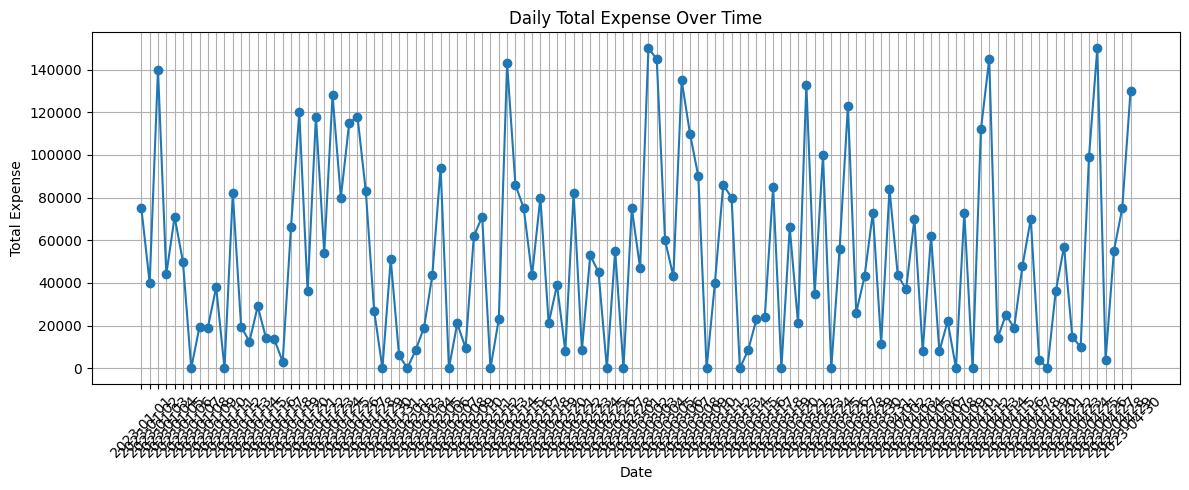

In [11]:
# Line Plot (Time Series Plot)
plt.figure(figsize=(12, 5))
plt.plot(daily_expense['Date'], daily_expense['Total_Expense'], marker='o')
plt.title('Daily Total Expense Over Time')
plt.xlabel('Date')
plt.ylabel('Total Expense')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **4. Data Preprocessing**

In [13]:
# Create a binary feature 'has_expense': 1 if Total_Expense > 0, else 0
daily_expense['has_expense'] = (daily_expense['Total_Expense'] > 0).astype(int)

In [14]:
# Ensure the 'Date' column is in datetime format
daily_expense['Date'] = pd.to_datetime(daily_expense['Date'])

# Extract the day of the week from the date (0 = Monday, ..., 6 = Sunday)
daily_expense['weekday'] = daily_expense['Date'].dt.weekday

# Create a binary feature 'is_weekend': 1 if the day is Saturday or Sunday, else 0
daily_expense['is_weekend'] = daily_expense['weekday'].isin([5,6]).astype(int)

# Extract the day of the month (1 to 31)
daily_expense['day_of_month'] = daily_expense['Date'].dt.day

# Extract the month (1 to 12)
daily_expense['month'] = daily_expense['Date'].dt.month

# Define a list of specific holiday dates
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])

# Create a binary feature 'is_holiday': 1 if the date is a holiday, else 0
daily_expense['is_holiday'] = daily_expense['Date'].isin(holidays).astype(int)

In [15]:
# Create MinMaxScaler instances for each feature
scaler_weekday = MinMaxScaler()
scaler_day = MinMaxScaler()
scaler_month = MinMaxScaler()
scaler_expense = MinMaxScaler()
scaler_flag = MinMaxScaler()

# Scale 'weekday' feature to range [0, 1]
daily_expense['weekday_scaled'] = scaler_weekday.fit_transform(daily_expense[['weekday']])

# Scale 'day_of_month' feature to range [0, 1]
daily_expense['day_of_month_scaled'] = scaler_day.fit_transform(daily_expense[['day_of_month']])

# Scale 'month' feature to range [0, 1]
daily_expense['month_scaled'] = scaler_month.fit_transform(daily_expense[['month']])

# Scale 'Total_Expense' feature to range [0, 1]
daily_expense['Total_Expense_scaled'] = scaler_expense.fit_transform(daily_expense[['Total_Expense']])

# Scale 'has_expense' binary flag to range [0, 1] (optional but consistent)
daily_expense['has_expense_scaled'] = scaler_flag.fit_transform(daily_expense[['has_expense']])

In [16]:
# Create lag features of scaled total expense for past 1, 2, and 3 days
daily_expense['lag_1'] = daily_expense['Total_Expense_scaled'].shift(1)
daily_expense['lag_2'] = daily_expense['Total_Expense_scaled'].shift(2)
daily_expense['lag_3'] = daily_expense['Total_Expense_scaled'].shift(3)

# Calculate 3-day moving average of scaled total expense
daily_expense['ma_3'] = daily_expense['Total_Expense_scaled'].rolling(window=3).mean()

# Fill any NaN values created by shifting and rolling with 0
daily_expense.fillna(0, inplace=True)

In [17]:
# Function to create sliding windows of data for multivariate time series
def create_multivariate_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Take a slice of 'window_size' rows as input features
        X.append(data[i:i+window_size])
        # Take the value of the first feature (Total_Expense_scaled) at the prediction day as target
        y.append(data[i+window_size][0])
    return np.array(X), np.array(y)

# List of features to use for the model
features = [
    'Total_Expense_scaled', 'has_expense', 'weekday_scaled',
    'is_weekend', 'day_of_month_scaled', 'month_scaled', 'is_holiday',
    'lag_1', 'lag_2', 'lag_3', 'ma_3'
]
# Convert selected features to numpy array
data_array = daily_expense[features].values
# Define the window size
window_size = 7
# Create input (X) and target (y) datasets using the sliding window function
X, y = create_multivariate_window(data_array, window_size)
print("Shape X:", X.shape)  # (num_samples, window_size, num_features)
print("Shape y:", y.shape)  # (num_samples,)

Shape X: (113, 7, 11)
Shape y: (113,)


# **5. Model Building and Evaluation**

In [18]:
# Build and train the LSTM model
model = Sequential()
# First Bidirectional LSTM layer with 150 units, returns sequences for stacking
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(window_size, len(features))))
# Dropout layer to reduce overfitting
model.add(Dropout(0.2))
# Second Bidirectional LSTM layer with 75 units
model.add(Bidirectional(LSTM(75)))
# Output layer with 1 unit (for regression output)
model.add(Dense(1))
# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer="adam", loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Train the model on the input data
model.fit(X, y, epochs=150, verbose=1, callbacks=[early_stop])

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1410
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0846
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0846
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0758
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0830
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0780
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0743
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0713
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0871
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0771
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0780
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0733
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0708
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0738
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0694
Epoch 16/150
4/4 ━━

In [20]:
# Predict scaled values using the trained model
y_pred_scaled = model.predict(X)
# Inverse transform predictions back to original expense scale
y_pred = scaler_expense.inverse_transform(y_pred_scaled)
# Inverse transform actual values back to original expense scale
y_true = scaler_expense.inverse_transform(y.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [21]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
# Calculate R-squared
r2 = r2_score(y_true, y_pred)
# Print evaluation metrics
print(f"\nEvaluation:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


Evaluation:
MSE  : 73787852.10
RMSE : 8589.99
R²   : 0.9599


In [22]:
# Display comparison between predictions and actual values
print("\nComparison: Predictions vs Actual:")
for i in range(min(20, len(y_pred))):
    print(f"Day {i+1+window_size}: Prediction = {y_pred[i][0]:,.2f} | Actual = {y_true[i][0]:,.2f}")


Comparison: Predictions vs Actual:
Day 8: Prediction = 23,636.56 | Actual = 19,500.00
Day 9: Prediction = 24,445.51 | Actual = 19,000.00
Day 10: Prediction = 42,415.90 | Actual = 38,000.00
Day 11: Prediction = 17,737.53 | Actual = 0.00
Day 12: Prediction = 78,889.58 | Actual = 82,000.00
Day 13: Prediction = 16,700.73 | Actual = 19,500.00
Day 14: Prediction = 12,971.40 | Actual = 12,500.00
Day 15: Prediction = 27,919.11 | Actual = 29,000.00
Day 16: Prediction = 17,517.60 | Actual = 14,000.00
Day 17: Prediction = 11,273.06 | Actual = 13,500.00
Day 18: Prediction = 7,474.03 | Actual = 3,000.00
Day 19: Prediction = 58,827.42 | Actual = 66,000.00
Day 20: Prediction = 118,565.75 | Actual = 120,000.00
Day 21: Prediction = 39,039.38 | Actual = 36,000.00
Day 22: Prediction = 118,385.05 | Actual = 118,000.00
Day 23: Prediction = 55,303.34 | Actual = 54,000.00
Day 24: Prediction = 120,321.84 | Actual = 128,000.00
Day 25: Prediction = 86,496.59 | Actual = 80,000.00
Day 26: Prediction = 123,802.50

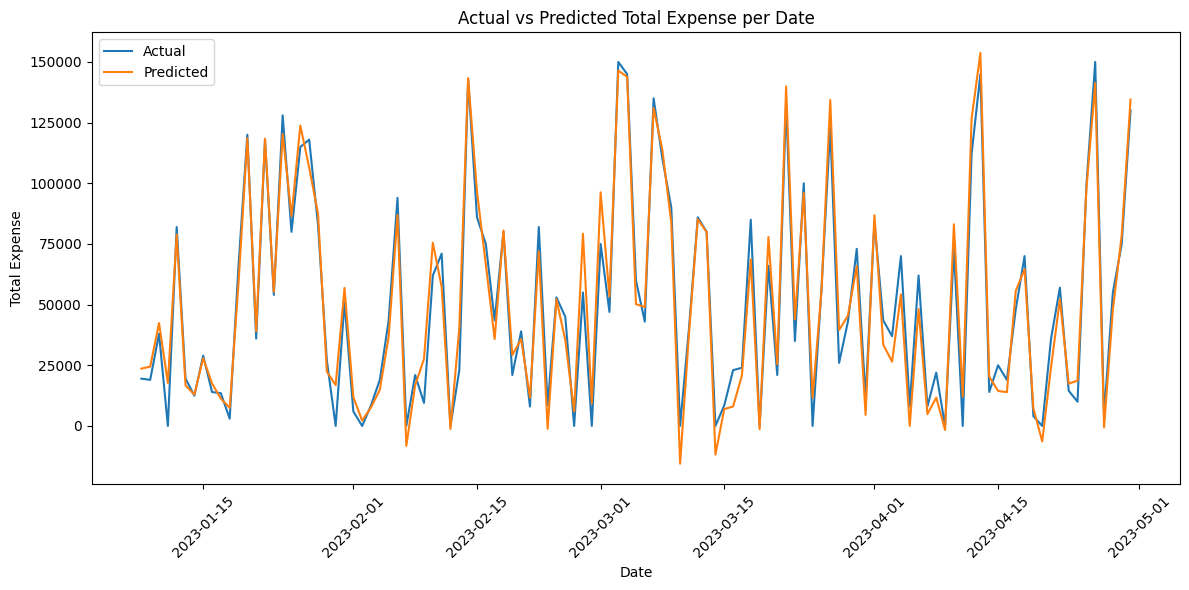

In [23]:
# Visualize actual vs predicted total expense per date
dates = daily_expense['Date'].iloc[window_size:window_size+len(y_true)]
plt.figure(figsize=(12, 6))
plt.plot(dates, y_true.flatten(), label='Actual')
plt.plot(dates, y_pred.flatten(), label='Predicted')
plt.title('Actual vs Predicted Total Expense per Date')
plt.xlabel('Date')
plt.ylabel('Total Expense')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **6. Inference**

In [24]:
# --- Initial Data ---
# Define a small sample dataset with dates and total expenses
data = {
    'Date': [
        '2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
        '2023-01-05', '2023-01-06', '2023-01-07'
    ],
    'Total_Expense': [
        75000, 40000, 140000, 44000, 71000, 90000, 35000
    ]
}
# Create DataFrame from dictionary
daily_expense = pd.DataFrame(data)

# --- Feature engineering ---
# 1. Create binary flag if there is any expense (1) or not (0)
daily_expense['has_expense'] = (daily_expense['Total_Expense'] > 0).astype(int)
# 2. Convert 'Date' column to datetime format
daily_expense['Date'] = pd.to_datetime(daily_expense['Date'])
# 3. Extract day of the week
daily_expense['weekday'] = daily_expense['Date'].dt.weekday
# 4. Create weekend flag
daily_expense['is_weekend'] = daily_expense['weekday'].isin([5, 6]).astype(int)
# 5. Extract day of the month
daily_expense['day_of_month'] = daily_expense['Date'].dt.day
# 6. Extract month
daily_expense['month'] = daily_expense['Date'].dt.month
# 7. Create holiday flag
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])
daily_expense['is_holiday'] = daily_expense['Date'].isin(holidays).astype(int)

# --- Feature Scaling ---
# Initialize scalers for various features
scaler_weekday = MinMaxScaler()
scaler_day = MinMaxScaler()
scaler_month = MinMaxScaler()
scaler_expense = MinMaxScaler()
scaler_flag = MinMaxScaler()
# Scale the numerical features
daily_expense['weekday_scaled'] = scaler_weekday.fit_transform(daily_expense[['weekday']])
daily_expense['day_of_month_scaled'] = scaler_day.fit_transform(daily_expense[['day_of_month']])
daily_expense['month_scaled'] = scaler_month.fit_transform(daily_expense[['month']])
daily_expense['Total_Expense_scaled'] = scaler_expense.fit_transform(daily_expense[['Total_Expense']])
daily_expense['has_expense_scaled'] = scaler_flag.fit_transform(daily_expense[['has_expense']])

# --- Lag Features (for time dependency modeling) ---
# Create lag features for previous 1, 2, and 3 days of scaled expense
daily_expense['lag_1'] = daily_expense['Total_Expense_scaled'].shift(1)
daily_expense['lag_2'] = daily_expense['Total_Expense_scaled'].shift(2)
daily_expense['lag_3'] = daily_expense['Total_Expense_scaled'].shift(3)

# --- Moving Average ---
# Calculate the 3-day moving average of the scaled expense
daily_expense['ma_3'] = daily_expense['Total_Expense_scaled'].rolling(window=3).mean()

# --- Handle Missing Values ---
# Fill any NaN values from lag and moving average with 0
daily_expense.fillna(0, inplace=True)

# Display the final DataFrame with all features
print(daily_expense)

        Date  Total_Expense  has_expense  weekday  is_weekend  day_of_month  \
0 2023-01-01          75000            1        6           1             1   
1 2023-01-02          40000            1        0           0             2   
2 2023-01-03         140000            1        1           0             3   
3 2023-01-04          44000            1        2           0             4   
4 2023-01-05          71000            1        3           0             5   
5 2023-01-06          90000            1        4           0             6   
6 2023-01-07          35000            1        5           1             7   

   month  is_holiday  weekday_scaled  day_of_month_scaled  month_scaled  \
0      1           0        1.000000             0.000000           0.0   
1      1           0        0.000000             0.166667           0.0   
2      1           0        0.166667             0.333333           0.0   
3      1           0        0.333333             0.500000          

In [25]:
# Define the features used for prediction
features = [
    'Total_Expense_scaled', 'has_expense_scaled', 'weekday_scaled',
    'is_weekend', 'day_of_month_scaled', 'month_scaled', 'is_holiday',
    'lag_1', 'lag_2', 'lag_3', 'ma_3'
]

# Set the window size
window_size = 7

# Take the most recent 'window_size' rows from the dataset
X_input = daily_expense[features].iloc[:window_size].values

# Add a new dimension to match model input shape (batch_size, window_size, num_features)
X_input = np.expand_dims(X_input, axis=0)

In [27]:
# Make prediction (scaled output)
pred_scaled = model.predict(X_input)[0][0]

# Inverse scale to get actual prediction value
pred_real = scaler_expense.inverse_transform([[pred_scaled]])[0][0]

# Show the result
print(f"Predicted Total Expense for Tomorrow: Rp {pred_real:,.0f}")
print("It is recommended to keep your spending below this predicted amount to stay on budget.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Total Expense for Tomorrow: Rp 94,538
It is recommended to keep your spending below this predicted amount to stay on budget.


# **7. Saving Model**

In [28]:
# Save the trained model to a .h5 file
model.save('model_pengeluaran.h5')

In [29]:
# Save all the scalers used during preprocessing
joblib.dump(scaler_weekday, 'scaler_weekday.pkl')
joblib.dump(scaler_day, 'scaler_day.pkl')
joblib.dump(scaler_month, 'scaler_month.pkl')
joblib.dump(scaler_expense, 'scaler_expense.pkl')
joblib.dump(scaler_flag, 'scaler_flag.pkl')

['scaler_flag.pkl']